# Trabajo práctico 1: Vectores, Matrices y Calculo Multi-variable
**Profesor Ph. D. Saúl Calderón Ramírez**

**Instituto Tecnológico de Costa Rica,**

**Escuela de Computación, programa en Ciencias de Datos,**

**Curso: Optimización y Programación Numérica**
_____________________________________________________________
**Fecha de entrega:** Domingo 22 de Marzo.

**Entrega**: Un archivo .zip con el código fuente LaTeX o Lyx, el pdf, y un jupyter en Pytorch, debidamente documentado, con una función definida por ejercicio. A través del TEC-digital.

**Modo de trabajo**: Grupos de 3 personas.

*En el presente trabajo práctico se repasarán aspectos básicos del algebra lineal, relacionados con los conceptos a desarrollar a lo largo del curso, mezclando aspectos teóricos y prácticos, usando el
lenguaje Python, con la librería Pytorch.*


---
**Elaborado por**:



*   Andres Chavarria Sibaja
*   Fernando Ugalde Green
*   Esteban Villalobos Gomez


---


In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pandas
import random

from google.colab import files

from scipy import ndimage

from sklearn.model_selection import train_test_split
import pandas as pd

from torch.distributions import normal
from torch.distributions import multivariate_normal
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device usado: {device}")

Device usado: cpu


#1.(20 pts) El producto punto y matrices


1. (5 pts) Demuestra que la norma $\ell_\infty$ cumple la propiedad de la homogeneidad absoluta.

    a. Muestre, usando 50 arreglos numericos generados aleatoriamente esta propiedad (adjunte el codigo en pytorch)

Pa generar los 50 ejemplos de arreglos numericos necesarios para esta propieda primeramente crearemos un serie de vectore de entradas numericas aleatorias y de logitudes aleatorias. Así tambien, crearemos un vector de valores de $\alpha$ aleatorios que será usados como valores para la comprobación

In [ ]:
vect_list = [torch.randn(random.randint(1, 10)) for _ in range(50)]
alpha_list = [torch.randn(1).item() for _ in range(50)]
scal_vect_list  = [alpha * vector for alpha, vector in zip(alpha_list, vect_list)]

En el codigo anterior **vect_list**, es una lista de vectores de logitudes aleatorias y con entradas numericas aleatorias, mientras **alpha_list** es una lista de valores de $\alpha$ y finalmente **scal_vect_list** es la lista de vectores escalados por el factor $\alpha$.

Ahora generamos un bucle for que calculara la norma al $l_{∞}$ para cada uno de los vectores, escalado y no escalado, de modo que para los no escalados, las normas seran luego multiplicadas por el alpha correspondiente y luego de esto será comparadas con las normas $l_{∞}$ de los vectores escalados. Finalmente se usara la fucnion de pytorch .isclose con una toleracions de $x10^{-5}$ para comprobar la igualdad entre ambas y se imprimiran los resultados para cada ejemplo:

In [ ]:
for idx, (vector, alpha, vector_escalado) in enumerate(zip(vect_list, alpha_list, scal_vect_list)):
    original_norm = torch.linalg.norm(vector, ord=float('inf'))
    scale_norm = torch.linalg.norm(vector_escalado, ord=float('inf'))
    cumple = torch.isclose(scale_norm, abs(alpha) * original_norm, atol=1e-5)

    print(f'[{idx+1}] Longitud: {vector.numel()}')
    print(f'Vector: {vector}')
    print(f'Alpha: {alpha}')
    print(f'Norma original L-inf: {original_norm.item()}')
    print(f'Norma escalada L-inf: {scale_norm.item()}')
    print(f'|alpha| * norma original: {abs(alpha) * original_norm}')
    print(f'Homogeneidad cumple: {cumple}\n')

[1] Longitud: 10
Vector: tensor([ 0.6455,  0.7992,  0.6037, -0.0463, -0.7691,  0.4138, -1.0906, -1.2578,
         1.2054,  0.2579])
Alpha: 1.5515027046203613
Norma original L-inf: 1.2577561140060425
Norma escalada L-inf: 1.9514119625091553
|alpha| * norma original: 1.9514119625091553
Homogeneidad cumple: True

[2] Longitud: 6
Vector: tensor([ 0.2854, -0.1760, -0.3272,  0.8605, -0.0574, -0.6856])
Alpha: -1.508812427520752
Norma original L-inf: 0.8605384230613708
Norma escalada L-inf: 1.2983911037445068
|alpha| * norma original: 1.2983911037445068
Homogeneidad cumple: True

[3] Longitud: 5
Vector: tensor([ 1.3697, -0.4313,  0.3424,  0.5220,  0.9290])
Alpha: -0.4632292091846466
Norma original L-inf: 1.3697031736373901
Norma escalada L-inf: 0.6344864964485168
|alpha| * norma original: 0.6344864964485168
Homogeneidad cumple: True

[4] Longitud: 5
Vector: tensor([-0.9323, -0.8520, -0.6999, -2.0426, -0.1167])
Alpha: -0.29735878109931946
Norma original L-inf: 2.042572259902954
Norma escalada L

2. (5 pts) Demuestra que si dos vectores $\vec{u}$ y $\vec{v}$ son ortogonales, entonces:

$\|\vec{u} + \vec{v}\| = \|\vec{u}\|^2 + \|\vec{v}\|^2$


  a. Muestre, usando 50 arreglos numericos generados aleatoriamente esta propiedad (adjunte el codigo en pytorch)



Para generar los 50 ejemplos de arreglos numericos para esta propiedad primeramente crearemos un generador de vectores ortogonales llamado **generador ortogonal**

In [ ]:
def generador_ortogonal(u):
    v = torch.randn_like(u)#recibimos al vector u y calculamos una proyeccion
    proyeccion = (torch.dot(u, v) / torch.dot(u, u)) * u
    v_ortogonal = v - proyeccion #usando la proyeccion calculamos el vector v ortogonal a u
    return v_ortogonal

AHora llamando a generador ortogonal, generamos una lista de pares de vectore $\vec{u}$ y $\vec{v}$ con los cuales realizaremos el calculo

In [ ]:
pares_ortogonales = [(u := torch.randn(random.randint(1, 10)),  # u aleatorio de longitud aleatoria
                      v := generador_ortogonal(u))#generamos el vector v a partir del vector u
                     for _ in range(50)]

Mediante el uso de un bucle for entonces procederemos a realizar los calculos necesarios y la comprobación. Finalmente, este código además imprimira los resultados.

In [ ]:
for idx, (u, v) in enumerate(pares_ortogonales):
    pp = torch.dot(u, v)

    u2_norm = torch.norm(u)**2
    v2_norm = torch.norm(v)**2
    sum2_norm = torch.norm(u + v)**2

    cumple = torch.isclose(sum2_norm, u2_norm + v2_norm, atol=1e-5)

    print(f'[{idx+1}] Longitud: {u.numel()}')
    print(f'u: {u}')
    print(f'v: {v}')
    print(f'Producto punto (debe ser 0): {pp.item()}')
    print(f'||u||^2: {u2_norm.item()}')
    print(f'||v||^2: {v2_norm.item()}')
    print(f'||u+v||^2: {sum2_norm.item()}')
    print(f'Suma de ||u||^2 + ||v||^2: {(u2_norm + v2_norm).item()}')
    print(f'Propiedad cumple: {cumple}\n')

[1] Longitud: 4
u: tensor([-1.1081,  0.8800, -0.5772,  1.8335])
v: tensor([-0.7303,  0.7566, -0.8643, -1.0766])
Producto punto (debe ser 0): 0.0
||u||^2: 5.697160243988037
||v||^2: 3.0120649337768555
||u+v||^2: 8.70922565460205
Suma de ||u||^2 + ||v||^2: 8.709224700927734
Propiedad cumple: True

[2] Longitud: 10
u: tensor([ 0.1985,  1.7082,  0.0309,  0.0917,  1.3010, -0.0805, -0.6983,  0.3358,
        -0.6442, -0.5881])
v: tensor([ 2.8883, -1.0558,  0.6812, -0.7013, -0.4858, -0.4114, -2.0677, -0.8502,
        -0.0507, -1.1586])
Producto punto (debe ser 0): 0.0
||u||^2: 6.0270209312438965
||v||^2: 17.16103172302246
||u+v||^2: 23.18805503845215
Suma de ||u||^2 + ||v||^2: 23.188053131103516
Propiedad cumple: True

[3] Longitud: 8
u: tensor([-0.1274,  0.5406, -2.3897,  0.6670, -0.5340, -0.5701, -0.6035,  0.6672])
v: tensor([-0.2867, -0.6382,  0.1800,  2.0211, -0.6780,  0.4083,  0.9024, -0.2910])
Producto punto (debe ser 0): 0.0
||u||^2: 7.883572578430176
||v||^2: 6.1321892738342285
||u+v||

3. Siendo las matrices $A,B \in \mathbb{R}^{n\times n}$ con $A+B=1_n$ y $AB=0_n$, demuestre $A^2=A$ y $B^2=B$

   a. Genere al menos un ejemplo numérico que muestre si tal propiedad se da.


Para el siguiente ejemplo generado nos daremos las siguiente matrices $A$ y $B$:

$A =\begin{pmatrix} 1 & 0 \\ 0 & 0 \end{pmatrix}$

$B = \begin{pmatrix} 0 & 0 \\ 0 & 1 \end{pmatrix}$



Creamos las matrices $A$ y $B$

In [ ]:
A = torch.tensor([[1., 0.],
                  [0., 0.]])

B = torch.tensor([[0., 0.],
                  [0., 1.]])

Calculamos las matrices $A^2=A$ y $B^2=B$ usando la función de pytorch *matmul*

In [ ]:
# Calculamos A^2
A2 = torch.matmul(A, A)

# Calculamos B^2
B2 = torch.matmul(B, B)

Tambien calculamos el producto $AB$ y $BA$:

In [ ]:
AB = torch.matmul(A, B)
BA = torch.matmul(B, A)

Ahora podemos comprobar la idempotencia de las matrices $A$ y $B$, usando la funcion **.allclose** de pytorch para todos lo productos calculados anteriormente:

In [ ]:
prop_A2_A = torch.allclose(A2, A)
prop_B2_B = torch.allclose(B2, B)
prop_AB_zero = torch.allclose(AB, torch.zeros_like(A))
prop_BA_zero = torch.allclose(BA, torch.zeros_like(B))

Finalmente  mostramos los resultados de las comprobaciones anteriores:

In [ ]:
print("Matriz A:\n", A)
print("Matriz B:\n", B)

print("\nA^2:\n", A2)
print("Propiedad A^2 = A:", prop_A2_A)

print("\nB^2:\n", B2)
print("Propiedad B^2 = B:", prop_B2_B)

print("\nAB:\n", AB)
print("Propiedad AB = 0:", prop_AB_zero)

print("\nAB:\n", BA)
print("Propiedad BA = 0:", prop_BA_zero)

print("\nBA (opcional):\n", BA)

Matriz A:
 tensor([[1., 0.],
        [0., 0.]])
Matriz B:
 tensor([[0., 0.],
        [0., 1.]])

A^2:
 tensor([[1., 0.],
        [0., 0.]])
Propiedad A^2 = A: True

B^2:
 tensor([[0., 0.],
        [0., 1.]])
Propiedad B^2 = B: True

AB:
 tensor([[0., 0.],
        [0., 0.]])
Propiedad AB = 0: True

AB:
 tensor([[0., 0.],
        [0., 0.]])
Propiedad BA = 0: True

BA (opcional):
 tensor([[0., 0.],
        [0., 0.]])


#2.(20 puntos) Funciones multivariable

## Funciones lineales multivariable

Un hiperplano definido en un espacio $\mathbb{R}^{n+1}$ se puede expresar como una función con dominio $\overrightarrow{x}\in\mathbb{R}^n$ y codominio en $\mathbb{R}$ como sigue: $z=f(\overrightarrow{x})=\overrightarrow{x}\cdot\overrightarrow{w}$, con $\overrightarrow{w}\in\mathbb{R}^n$ el arreglo de coeficientes de tal funcional.

1. Tómese $\overrightarrow{w}_1=\begin{bmatrix}0.5\\0.2\end{bmatrix}$ para la función $f_1$ y $\overrightarrow{w}_2=\begin{bmatrix}-0.1\\0.05\end{bmatrix}$ para la función $f_2$, (funciones con dominio en $\mathbb{R}^2$ y codominio en $\mathbb{R}$). Grafique ambos planos en Pytorch.

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


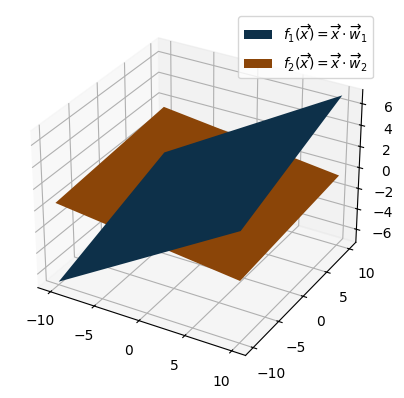

In [30]:
import matplotlib.pyplot as plt
import torch

w1 = torch.tensor([0.5, 0.2])
w2 = torch.tensor([-0.1, 0.05])

def f(w, x, y):
  return w[0] * x + w[1] * y

x = torch.linspace(-10, 10, 2)
x, y = torch.meshgrid(x, x)

z1 = f(w1, x, y)
z2 = f(w2, x, y)

ax = plt.subplot(projection='3d')
ax.plot_surface(x, y, z1, label='$f_1(\overrightarrow{x})=\overrightarrow{x}\cdot\overrightarrow{w}_1$')
ax.plot_surface(x, y, z2, label='$f_2(\overrightarrow{x})=\overrightarrow{x}\cdot\overrightarrow{w}_2$')
ax.legend()
plt.show()

2. Para cada plano, grafique el vector normal en el punto $P=(1,1)$ y una curva de nivel perpendicular a tal vector normal. Calcule el vector gradiente en tal punto, y demuestre que ese vector gradiente es perpendicular a la curva de nivel previamente dibujada.

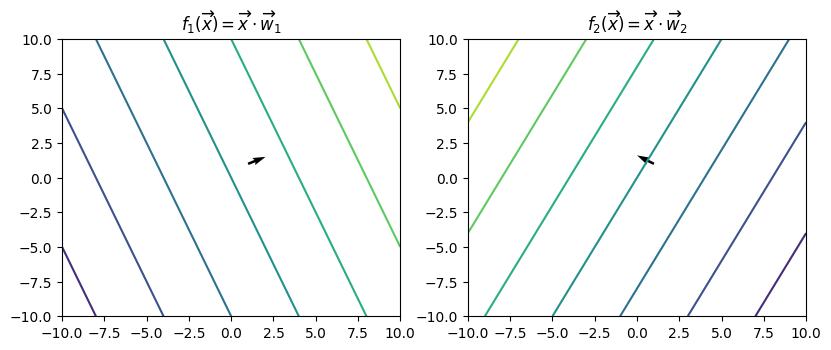

In [31]:
f1_grad = [0.5, 0.2]
f2_grad = [-0.1, 0.05]

fig, axes = plt.subplots(1, 2, figsize=(9.6, 3.6))

axes[0].set_title('$f_1(\overrightarrow{x})=\overrightarrow{x}\cdot\overrightarrow{w}_1$')
axes[0].contour(x, y, z1)
axes[0].quiver(1, 1, *f1_grad)

axes[1].set_title('$f_2(\overrightarrow{x})=\overrightarrow{x}\cdot\overrightarrow{w}_2$')
axes[1].contour(x, y, z2)
axes[1].quiver(1, 1, *f2_grad)

plt.show()

Para demostrar que $\nabla f_1$ es perpendicular a la curva de nivel en $(1,1)$, basta con mostrar que el producto punto entre $\nabla f_1$ y $[1,1,f_1(1,1)]$ da como resultado 0.

\begin{equation}
f_1(\overrightarrow{x})=f_1(x,y)=0.5x+0.2y=z\Rightarrow 0.5x+0.2y-z=0
\end{equation}

\begin{equation}
\begin{array}{rcl}
\nabla f_1\cdot[1,1,f_1(1,1)]&=&\left[\frac{df_1}{dx},\frac{df_1}{dy},\frac{df_1}{dz}\right]\cdot[1,1,0.5+0.2]\\
&=&[0.5,0.2,-1]\cdot[1,1,0.7]\\
&=&0.5\cdot1+0.2\cdot1-1\cdot0.7\\
&=&0
\end{array}
\end{equation}

Para demostrar que $\nabla f_2$ es perpendicular a la curva de nivel en $(1,1)$, basta con mostrar que el producto punto entre $\nabla f_2$ y $[1,1,f_2(1,1)]$ da como resultado 0.

\begin{equation}
f_2(\overrightarrow{x})=f_2(x,y)=-0.1x+0.05y=z\Rightarrow -0.1x+0.05y-z=0
\end{equation}

\begin{equation}
\begin{array}{rcl}
\nabla f_2\cdot[1,1,f_2(1,1)]&=&\left[\frac{df_2}{dx},\frac{df_2}{dy},\frac{df_2}{dz}\right]\cdot[1,1,-0.1+0.05]\\
&=&[-0.1,0.05,-1]\cdot[1,1,-0.05]\\
&=&-0.1\cdot1+0.05\cdot1+1\cdot0.05\\
&=&0
\end{array}
\end{equation}

## El vector gradiente

Para cada una de las siguientes funciones multivariable:

\begin{equation}
\begin{array}{l}
f_1(x,y)=(1.5-x+xy)^2+(2.25-x+xy^2)+(2.625-x+xy^3)\\
f_2(x,y)=(x+2y-7)^2+(2x+y-5)^2\\
f_3(x,y)=100\sqrt{|y-0.01x^2|}+0.01|x+10|
\end{array}
\end{equation}

1. Grafique su superficie con dominio entre -10 y 10.

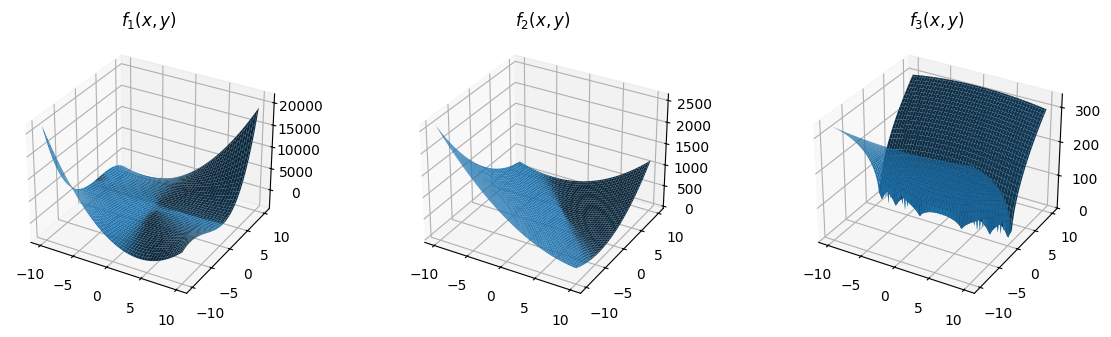

In [32]:
def f1(x, y):
  return (1.5 - x + x * y)**2 + (2.25 - x + x * y**2) + (2.625 - x + x * y**3)

def f2(x, y):
  return (x + 2 * y - 7)**2 + (2 * x + y - 5)**2

def f3(x, y):
  return 100 * torch.sqrt(abs(y - 0.01 * x**2)) + 0.01 * abs(x + 10)

x = torch.linspace(-10, 10, 100)
x, y = torch.meshgrid(x, x)

def plot_surface(i, f):
  ax = fig.add_subplot(1, 3, i, projection='3d')
  ax.set_title(f'$f_{i}(x,y)$')
  ax.plot_surface(x, y, f(x, y))

fig = plt.figure(figsize=(14.4, 3.6))

plot_surface(1, f1)
plot_surface(2, f2)
plot_surface(3, f3)

plt.show()

2. Calcule el vector gradiente manualmente, evalúelo y grafique el vector unitario en la dirección del gradiente para los dos puntos especificados (en la misma figura de la superficie).

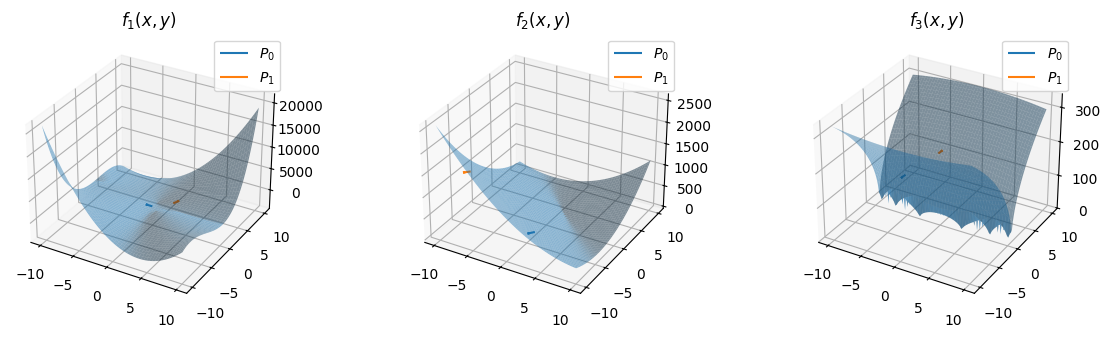

In [33]:
def f1_grad(x, y):
  dx = 2 * (1.5 - x + x * y) * (-1 + y) + (-1 + y**2) + (-1 + y**3)
  dy = 2 * (1.5 - x + x * y) * x + (2 * x * y) + (3 * x * y**2)

  return torch.tensor([dx, dy], dtype=float)

def f2_grad(x, y):
  dx = 2 * (x + 2 * y - 7) + 4 * (2 * x + y - 5)
  dy = 4 * (x + 2 * y - 7) + 2 * (2 * x + y - 5)

  return torch.tensor([dx, dy], dtype=float)

def f3_grad(x, y):
  u = y - 0.01 * x**2

  dx = -x * torch.sign(u) / (torch.sqrt(abs(u))) + 0.01 * torch.sign(x + 10)
  dy = 50 * torch.sign(u) / (torch.sqrt(abs(u)))

  return torch.tensor([dx, dy], dtype=float)

def plot_surface(i, f, f_grad, p0, p1):
  p0 = torch.tensor(p0)
  p1 = torch.tensor(p1)

  p0_grad = f_grad(*p0)
  p1_grad = f_grad(*p1)

  ax = fig.add_subplot(1, 3, i, projection='3d')
  ax.set_title(f'$f_{i}(x,y)$')
  ax.plot_surface(x, y, f(x, y), alpha=0.5)

  ax.quiver(*p0, f(*p0), *p0_grad, -1, normalize=True, color='tab:blue', label='$P_0$')
  ax.quiver(*p1, f(*p1), *p1_grad, -1, normalize=True, color='tab:orange', label='$P_1$')

  ax.legend()

fig = plt.figure(figsize=(14.4, 3.6))

plot_surface(1, f1, f1_grad, (0, 0), (2, 2))
plot_surface(2, f2, f2_grad, (1.5, -5.5), (-7, -7))
plot_surface(3, f3, f3_grad, (-4, -2), (-2, 3))

plt.show()

3. Calcule la magnitud de tal vector gradiente en cada punto.

P_0 grad: tensor([-5.,  0.], dtype=torch.float64)
P_1 grad: tensor([17., 46.], dtype=torch.float64)

Magnitud del vector gradiente de f_1 en P_0: 5.0
Magnitud del vector gradiente de f_1 en P_1: 49.040799340956916

P_0 grad: tensor([-63., -81.], dtype=torch.float64)
P_1 grad: tensor([-160., -164.], dtype=torch.float64)

Magnitud del vector gradiente de f_2 en P_0: 102.61578825892242
Magnitud del vector gradiente de f_2 en P_1: 229.12005586591496

P_0 grad: tensor([ -2.7117, -34.0207], dtype=torch.float64)
P_1 grad: tensor([ 1.1725, 29.0619], dtype=torch.float64)

Magnitud del vector gradiente de f_3 en P_0: 34.128587491043824
Magnitud del vector gradiente de f_3 en P_1: 29.085550355725932



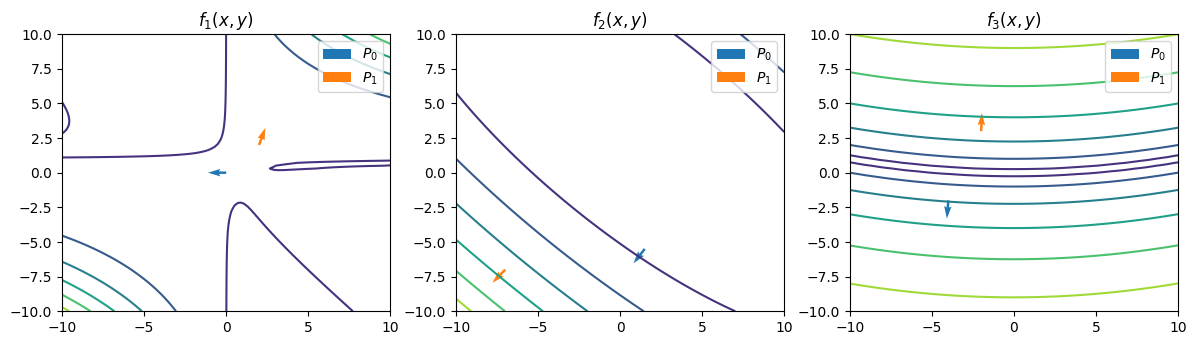

In [34]:
def plot(ax_index, f, f_grad, p0, p1):
  p0 = torch.tensor(p0)
  p1 = torch.tensor(p1)

  p0_grad = f_grad(*p0)
  p1_grad = f_grad(*p1)

  print('P_0 grad:', p0_grad)
  print('P_1 grad:', p1_grad)
  print()

  print(f'Magnitud del vector gradiente de f_{ax_index + 1} en P_0: {torch.norm(p0_grad)}')
  print(f'Magnitud del vector gradiente de f_{ax_index + 1} en P_1: {torch.norm(p1_grad)}')
  print()

  axes[ax_index].set_title(f'$f_{ax_index + 1}(x,y)$')
  axes[ax_index].contour(x, y, f(x, y))

  axes[ax_index].quiver(*p0, *p0_grad, color='tab:blue', label='$P_0$')
  axes[ax_index].quiver(*p1, *p1_grad, color='tab:orange', label='$P_1$')

  axes[ax_index].legend()

fig, axes = plt.subplots(1, 3, figsize=(14.4, 3.6))

plot(0, f1, f1_grad, (0, 0), (2, 2))
plot(1, f2, f2_grad, (1.5, -5.5), (-7, -7))
plot(2, f3, f3_grad, (-4, -2), (-2, 3))

plt.show()

4. Calcule lo que se conoce como la matriz Hessiana.

In [35]:
def f1_hessian(x, y):
  dxx = 2 * (y - 1)**2
  dxy = 2 * (1.5 - 2 * x + 2 * x + y) + 2 * y + 3 * y**2
  dyy = 2 * x**2 + 2 * x + 6 * x * y

  return torch.tensor([
    [dxx, dxy],
    [dxy, dyy],
  ])

def f2_hessian(x, y):
  dxx = 10
  dxy = 8
  dyy = 10

  return torch.tensor([
    [dxx, dxy],
    [dxy, dyy],
  ])

def f3_hessian(x, y):
  x, y = torch.tensor([x, y])

  u = y - 0.01 * x**2

  dxx = -torch.sign(u) / torch.sqrt(abs(u)) - 0.01 * x**3 / abs(u)**(3 / 2)
  dxy = x / (2 * abs(u)**(3 / 2))
  dyy = -25 / abs(u)**(3 / 2)

  return torch.tensor([
    [dxx, dxy],
    [dxy, dyy],
  ])

def foo(f, i, p0, p1):
  print(f'Hessiana de f_{i} en P_0:\n{f(*p0)}\n')
  print(f'Hessiana de f_{i} en P_1:\n{f(*p1)}\n')

foo(f1_hessian, 1, (0, 0), (2, 2))
foo(f2_hessian, 2, (1.5, -5.5), (-7, -7))
foo(f3_hessian, 3, (-4, -2), (-2, 3))

Hessiana de f_1 en P_0:
tensor([[2., 3.],
        [3., 0.]])

Hessiana de f_1 en P_1:
tensor([[ 2., 23.],
        [23., 36.]])

Hessiana de f_2 en P_0:
tensor([[10,  8],
        [ 8, 10]])

Hessiana de f_2 en P_1:
tensor([[10,  8],
        [ 8, 10]])

Hessiana de f_3 en P_0:
tensor([[ 0.8820, -0.6300],
        [-0.6300, -7.8752]])

Hessiana de f_3 en P_1:
tensor([[-0.5655, -0.1964],
        [-0.1964, -4.9091]])



# 3.(60 puntos) Implementación del algoritmo K-vecinos mas cercanos

---
El algoritmo de K-vecinos mas cercanos es un algoritmo de aprendizaje
automatico supervisado muy popular por su simplicidad. Dado un conjunto
de datos representado matricialmente en la matriz $X_{\textrm{train}}\in\mathbb{R}^{N\times D}$
y un arreglo de etiquetas $\overrightarrow{t}\in\mathbb{R}^{N}$:
\[
X_{\textrm{train}}=\begin{bmatrix}- & \overrightarrow{x}_{1} & -\\
 & \vdots\\
- & \overrightarrow{x}_{N_{\textrm{train}}} & -
\end{bmatrix}\qquad\overrightarrow{t}=\begin{bmatrix}t_{1}\\
\vdots\\
t_{N_{\textrm{train}}}
\end{bmatrix}
\]
Para cada dato $\overrightarrow{x}_{i}^{\left(\textrm{test}\right)}\in X_{\textrm{test}}$
en un conjunto de datos de prueba o evaluacion $X_{\textrm{test}}\in\mathbb{R}^{N_{\textrm{test}}\times D}$:
\[
X_{\textrm{test}}=\begin{bmatrix}- & \overrightarrow{x}_{1} & -\\
 & \vdots\\
- & \overrightarrow{x}_{N} & -
\end{bmatrix}
\]
se crea un conjunto de datos $X_{\textrm{KNN}}$ con los $K$ vecinos
mas cercanos de la observacion $\overrightarrow{x}_{j}$ en el conjunto
de datos $X_{\textrm{train}}$, donde cada observacion $\overrightarrow{x}_{i}\in X_{\textrm{KNN}}$
cumple que:
\[
X_{\textrm{KNN}}=\arg\min_{K\:\textrm{min}\:j}\left(d\left(\overrightarrow{x}_{i}^{\left(\textrm{test}\right)}-\overrightarrow{x}_{j}\right)\right)
\]

Luego de tomar los K vecinos mas cercanos de la observacion $\overrightarrow{x}_{i}^{\left(\textrm{test}\right)}$
se realiza una votación según las etiquetas correspondientes $t_{i}^{\left(\textrm{test}\right)}$,
y se toma como estimacion de la etiqueta $\widetilde{t}_{j}$ la etiqueta
mas votada.



## Creacion de datos artificiales (provisto por el profesor)

> Data are created artificially with a mixed Gaussian distribution of two clusters, with specific means and standard deviations

In [2]:
def create_data(numberSamplesPerClass = 2, mean1 = [2, 2], mean2 = [26, 26], stds1 = [3, 3], stds2 = [2, 1]):
    """
    Creates the data to be used for training, using a GMM distribution
    @param numberSamplesPerClass, the number of samples per class
    @param mean1, means for samples from the class 1
    @param mean2, means for samples from the class 2
    @param stds1, standard deviation for samples, class 1
    @param stds2, standard deviation for samples, class 2    """
    means = torch.zeros(2)
    # Ones to concatenate for bias
    ones = torch.ones(numberSamplesPerClass, 1)
    means[0] = mean1[0]
    means[1] = mean1[1]
    # Covariance matrix creation with identity
    covarianceMatrix = torch.eye(2)
    covarianceMatrix[0, 0] = stds1[0]
    covarianceMatrix[1, 1] = stds1[1]
    samplesClass1 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)
    means[0] = mean2[0]
    means[1] = mean2[1]
    covarianceMatrix[0, 0] = stds2[0]
    covarianceMatrix[1, 1] = stds2[1]
    samplesClass2 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)
    # Concatenates the ones for the bias
    samplesClass1Bias = torch.cat((ones, samplesClass1), 1)
    samplesClass2Bias = torch.cat((ones, samplesClass2), 1)
    samplesAll = torch.cat((samplesClass1, samplesClass2), 0)
    plt.scatter(samplesClass1[:, 0], samplesClass1[:, 1])
    plt.scatter(samplesClass2[:, 0], samplesClass2[:, 1], marker = 'x')
    plt.show()
    #Create samples without bias
    samplesAll = torch.cat((samplesClass1, samplesClass2), 0)

    #Create targets
    targetsClass1 = torch.ones(numberSamplesPerClass, 1)
    targetsClass2 = torch.zeros(numberSamplesPerClass, 1)
    targetsAll = torch.cat((targetsClass1, targetsClass2), 0)

    return (targetsAll, samplesAll)


'''
Creates data with gaussian distribution
'''
def createDataOneClass(means, covarianceMatrix, numberSamples):
    # Inits the bi gaussian data generator
    multiGaussGenerator = multivariate_normal.MultivariateNormal(means, covarianceMatrix)
    # Takes the samples
    samples = multiGaussGenerator.sample(torch.Size([numberSamples]))

    return samples

## Plot de datos

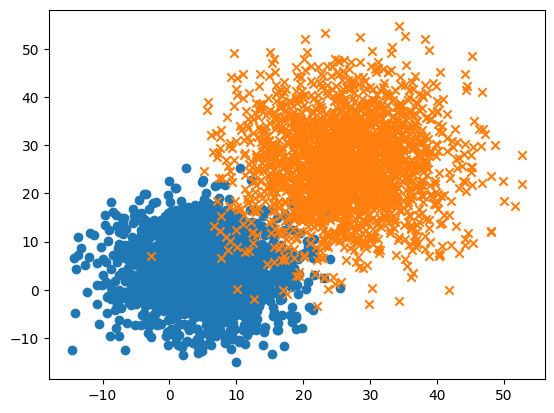

In [ ]:
(targetsAll, samplesAll) = create_data(numberSamplesPerClass = 2000, mean1 = [5, 4],  mean2 = [26, 26], stds1 = [40, 40], stds2 = [60, 90])

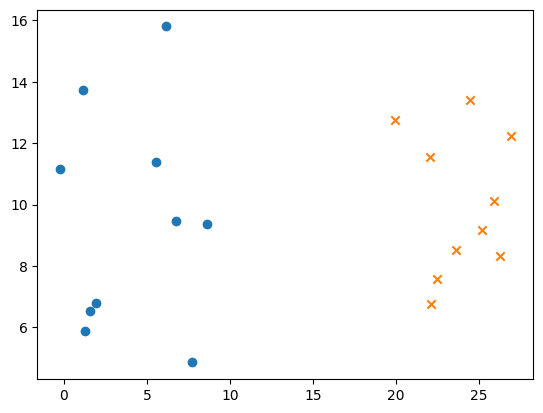

In [ ]:
(targetsAll, samplesAll) = create_data(numberSamplesPerClass = 10, mean1 = [5,10], mean2 = [25, 10], stds1 = [10, 10], stds2 = [9, 9])

## 1.(20 puntos) Implemente el algoritmo de K-vecinos mas cercanos con la posibilidad de usar la distancia euclidiana, de Manhattan, Infinito en la funcion $d\left(\overrightarrow{x}_{i}-\overrightarrow{x}_{j}\right)$.

a)   Realice la implementacion de forma completamente matricial, para cada observacion $\overrightarrow{x}_{i}^{\left(\textrm{test}\right)}$
  
  *evaluate\_k\_nearest\_neighbors\_observation( data\_training, labels\_training, test\_observation, K = 7, p = 2)* (**No use ciclos for**).


1.   Para ello use funcionalidades de *pytorch* como *repeat*, *mode*, *sort*, etc.
2.   **p** indica el tipo de norma a utilizar. $K$ corresponde a la cantidad de vecinos a evaluar.
3.   Diseñe al menos 2 pruebas unitarias para esta funcion.

b)   Para todo el conjunto de datos $X_{\textrm{test}}$ implemente la funcion *evaluate\_k\_nearest\_neighbors\_test\_dataset(data\_training, labels\_training, test\_dataset, K = 3, is\_euclidian = True)*, la cual utilice la funcion previamente construida *evaluate\_k\_nearest\_neighbors\_observation* para calcular el arreglo de estimaciones $\overrightarrow{\widetilde{t}}$ para todos los datos en $X_{\textrm{test}}$.


c)   Implemente la funcion *calcular\_tasa\_aciertos* la cual tome un arreglo de estimaciones $\overrightarrow{\widetilde{t}}$ y un arreglo de etiquetas $\overrightarrow{x}_{i}^{\left(\textrm{test}\right)}$ y calcule la tasa de aciertos definida como $\frac{c}{N}$ donde $c$ es la cantidad de estimaciones correctas. **(No use ciclos for)**.




### 1. Implementacion

In [3]:
#1.a
def evaluate_k_nearest_neighbors_observation(data_training, labels_training, test_observation, k=7, p=2.0, debug=False):

  # Calcula la distancia entre la observacion de entrada y el resto del dataset.
  if p == float('inf'):
    dist = torch.max(torch.abs(data_training - test_observation), dim=1).values.unsqueeze(0)
  else:
    dist = torch.pow(torch.sum(torch.pow(torch.abs(data_training - test_observation), p), dim=1), 1/p).unsqueeze(0)

  if(debug):
    print(f"Distancia {p}:\t{dist}")

  # Se seleccionan los K indices con las menores distancias
  k_vecinos = dist.topk(k, largest=False)

  # Extraccion de los labels de los vecinos mas cercanos
  target_labels = labels_training[k_vecinos.indices[0]]

  # La moda se puede usar para obtener el valor más repetido
  # Este valor se convierte en la etiqueta estimada
  return torch.mode(target_labels, 0).values.unsqueeze(0)

#1.b
def evaluate_k_nearest_neighbors_test_dataset(data_training, labels_training, test_dataset, k=3, p=float('inf')):
  """
  Se elimina la variable de la especificacion is_euclidean, pues se deben soportar tres normas:
  p = [1, 2, float('inf')]
  """
  # t_estimated_dataset = evaluate_k_nearest_neighbors_observation(data_training, labels_training, test_dataset, k, p)
  # calcula el knn para cada observacion del test_dataset
  t_estimated_dataset = [
    evaluate_k_nearest_neighbors_observation(data_training, labels_training, test_observation, k, p)
      for test_observation in test_dataset
    ]

  # retorna un tensor en la misma arquitectura que el tensor de data_training
  return torch.tensor(t_estimated_dataset).to(data_training.device)

#1.c
def calcular_tasa_aciertos(test_estimations, test_labels):
  """ Calcula la tasa de aciertos """
  comparison = torch.eq(test_estimations, test_labels)
  return torch.count_nonzero(comparison, dim=0).item() / test_labels.shape[0]


### Pruebas unitarias

#### Unit tests de `evaluate_k_nearest_neighbors_observation`

ut_data shape:		torch.Size([5, 2])
ut_labels shape:	torch.Size([5, 1])


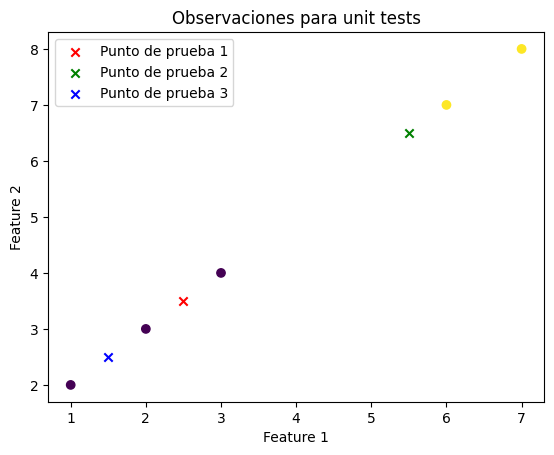

In [ ]:
# Datos de prueba
ut_data = torch.tensor([[1.0, 2.0], [2.0, 3.0], [3.0, 4.0], [6.0, 7.0], [7.0, 8.0]])
ut_labels = torch.tensor([0, 0, 0, 1, 1]).unsqueeze(1)  # Dos clases: 0 y 1

#Puntos a evaluar
punto1 = torch.tensor([2.5, 3.5]) # clase 0
punto2 = torch.tensor([5.5, 6.5]) # clase 1
punto3 = torch.tensor([1.5, 2.5]) # clase 0

print(f'ut_data shape:\t\t{ut_data.shape}\nut_labels shape:\t{ut_labels.shape}')

# Plotting datos de prueba
plt.scatter(ut_data[:, 0], ut_data[:, 1], c=ut_labels.squeeze())

# Plotting puntos especificos de pruebas
plt.scatter(punto1[0], punto1[1], color='red', marker='x', label='Punto de prueba 1')
plt.scatter(punto2[0], punto2[1], color='green', marker='x', label='Punto de prueba 2')
plt.scatter(punto3[0], punto3[1], color='blue', marker='x', label='Punto de prueba 3')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Observaciones para unit tests')
plt.legend()
plt.show()

In [ ]:
# Test bench

def ut_p(test_point, expected_class, p):
  test_estimations_all = evaluate_k_nearest_neighbors_observation(ut_data, ut_labels, test_point, k = 2, p=p, debug=True)
  print("Clase estimada: ", test_estimations_all.squeeze(1))
  print("Clase esperada: ", torch.tensor([0]))
  if torch.equal(test_estimations_all.squeeze(1), expected_class):
    print(f"Test {p} passed")
    return True

  print(f"Test {p} failed")
  return False

**Ejecucion de pruebas**

In [ ]:
pruebas = []
print("Unit test 1")
pruebas.append(ut_p(punto1, torch.tensor([0]), 1.0))
print("Unit test 2")
pruebas.append(ut_p(punto2, torch.tensor([1]), 1.0))
print("Unit test 3")
pruebas.append(ut_p(punto3, torch.tensor([0]), 1.0))

Unit test 1
Distancia 1.0:	tensor([[3., 1., 1., 7., 9.]])
Clase estimada:  tensor([0])
Clase esperada:  tensor([0])
Test 1.0 passed
Unit test 2
Distancia 1.0:	tensor([[9., 7., 5., 1., 3.]])
Clase estimada:  tensor([1])
Clase esperada:  tensor([0])
Test 1.0 passed
Unit test 3
Distancia 1.0:	tensor([[ 1.,  1.,  3.,  9., 11.]])
Clase estimada:  tensor([0])
Clase esperada:  tensor([0])
Test 1.0 passed


#### Unit tests de `evaluate_k_nearest_neighbors_test_dataset`

In [ ]:
test_estimations_all = evaluate_k_nearest_neighbors_test_dataset(ut_data, ut_labels, ut_data, k = 2, p=2.0)
pruebas.append(torch.equal(test_estimations_all, ut_labels.squeeze(1)))
print(f'Test 4 {"passed" if pruebas[-1] else "failed"}')

Test 4 passed


In [ ]:
test_estimations_all = evaluate_k_nearest_neighbors_test_dataset(ut_data, ut_labels, ut_data, k = 2, p= float('inf'))
pruebas.append(torch.equal(test_estimations_all, ut_labels.squeeze(1)))
print(f'Test 5 {"passed" if  pruebas[-1] else "failed"}')

Test 5 passed


#### Resultado de pruebas unitarias

In [ ]:
pruebas_df = pd.DataFrame({'Prueba': ['Prueba ' + str(i+1) for i in range(len(pruebas))], 'Passed': pruebas})
display(pruebas_df)

,Prueba,Passed
0,Prueba 1,True
1,Prueba 2,True
2,Prueba 3,True
3,Prueba 4,True
4,Prueba 5,True


## 2.Para un conjunto de datos de $N=1000000$ (500000 observaciones por clase) genere un conjunto de datos con medias $\mu_{1}=\left[12,12\right]^{T}$, $\mu_{2}=\left[20,20\right]^{T}$, y desviaciones estandar $\sigma_{1}=\left[3,3\right]^{T}$, $\sigma_{2}=\left[2,2\right]^{T}$. Grafique los datos y muestre las figuras.

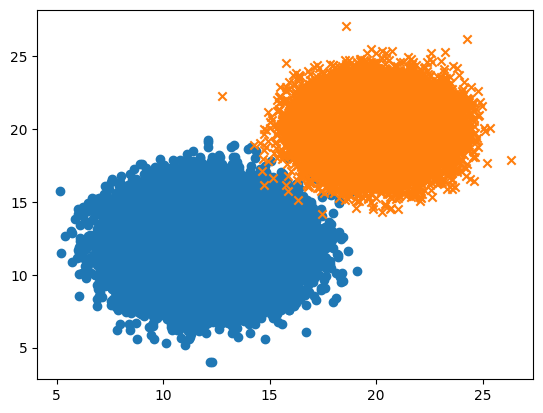

TargetsAll device=cuda:0, SamplesAll device=cuda:0
TargetsAll shape=torch.Size([100000, 1]), SamplesAll shape=torch.Size([100000, 2])


In [ ]:
(TargetsAll, SamplesAll) = create_data(numberSamplesPerClass=50000,
                                       mean1=[12, 12],
                                       mean2=[20, 20],
                                       stds1=[3, 3],
                                       stds2=[2, 2])

if torch.cuda.is_available():
  SamplesAll = SamplesAll.to(device)
  TargetsAll = TargetsAll.to(device)

print(f'TargetsAll device={TargetsAll.device}, SamplesAll device={SamplesAll.device}')
print(f'TargetsAll shape={TargetsAll.shape}, SamplesAll shape={SamplesAll.shape}')

## 3.(**10 puntos**) Compruebe y compare para las distancias implementadas, usando el dataset anterior, y K = 7:


a)    La tasa de aciertos, definida como $\frac{c}{N}$ donde $c$ es la cantidad de estimaciones correctas, usando el mismo conjunto de datos $X_{\textrm{train}}$ como conjunto de prueba $X_{\textrm{test}}$. Documente los resultados y comentelos. Puede probar otros valores de medias que faciliten la separabilidad de los datos para facilitar la explicacion.

b)    Usando las funciones de particion de datos del paquete *sklearn* necesarias, implemente la particion de datos del conjunto de datos original $X$ para crear las particiones $X_{\textrm{train}}$ y $X_{\textrm{test}}$. Cree 10 particiones distintas, para ejecutar 10 veces el codigo.


1.    Utilice 70\% de los datos para entrenamiento y el resto para prueba.
2.    Calcule la tasa de aciertos para las configuraciones (distancia $\ell_{1}$,$\ell_{2}$ y $\ell_{∞}$) probadas, usando $X_{\textrm{train}}$ para entrenamiento y $X_{\textrm{test}}$ para prueba. Reporte los resultados en una tabla, junto con su media y desviacion estandar y comentelos.
3.    Calcule ademas el *tiempo de ejecucion* por corrida para cada las tres distancias tanto en CPU como en GPU. Reporte los resultados en una tabla para las 10 corridas, junto con su media y desviacion estandar y comentelos.


*   $a'$ Realice una grafica comparativa.
*   $b'$ Cual distancia resulto mas eficiente?
*   $c'$ Hay algun costo en cuanto a la tasa de aciertos? Explique el porque de la diferencia en la tasa de aciertos, si la hay.

In [ ]:
# Estima KNN con K=7 utilizando el conjunto de datos completo con distancia euclidiana
test_estimations_all = evaluate_k_nearest_neighbors_test_dataset(SamplesAll, TargetsAll, SamplesAll, k = 7, p=2.0)
accuracy = calcular_tasa_aciertos(test_estimations_all.unsqueeze(0).transpose(0, 1), TargetsAll)
print("Tasa de aciertos con Distancia Euclideana: ", accuracy)



Tasa de aciertos con Distancia Euclideana:  0.99978


In [ ]:
# Estima KNN con K=7 utilizando el conjunto de datos completo con distancia Manhattan
test_estimations_all = evaluate_k_nearest_neighbors_test_dataset(SamplesAll, TargetsAll, SamplesAll, k = 7, p = 1.0)

#calculate accuracy for Manhattan distance
accuracy = calcular_tasa_aciertos(test_estimations_all.unsqueeze(0).transpose(0, 1), TargetsAll)
print("Tasa de aciertos con Distancia Manhattan: ", accuracy)

Tasa de aciertos con Distancia Manhattan:  0.99979


In [ ]:
# Estima KNN con K=7 utilizando el conjunto de datos completo con distancia Infinita
test_estimations_all = evaluate_k_nearest_neighbors_test_dataset(SamplesAll, TargetsAll, SamplesAll, k = 7, p = float('inf'))

#calculate accuracy for Infinita distance
accuracy = calcular_tasa_aciertos(test_estimations_all.unsqueeze(0).transpose(0, 1), TargetsAll)
print("Tasa de aciertos con Distancia Infinita: ", accuracy)

Tasa de aciertos con Distancia Infinita:  0.99982


#### GPU test

In [14]:
# Genera 10 semillas aleatorias

# seeds = random.sample(range(1, 1000000), 10)
seeds = [708074, 866179, 195297, 792108, 501205, 507098, 74913, 566218, 592739, 282385]
# Imprime las semillas utilizadas (para reproducibilidad)
print(seeds)

[708074, 866179, 195297, 792108, 501205, 507098, 74913, 566218, 592739, 282385]


In [4]:
# 3.b GPU
def evalua_con_repeticiones(samples, targets, k=7, reps = 10):
  results = {
      'Accuracy_Euclidean': [],
      'Duration_Euclidean': [],
      'Accuracy_Manhattan': [],
      'Duration_Manhattan': [],
      'Accuracy_Infinity': [],
      'Duration_Infinity': []
  }

  for index in range(reps):
      # Create Train/Test sets
      X_train, X_test, y_train, y_test = train_test_split(samples,
                                                          targets,
                                                          test_size=0.30,
                                                          random_state=seeds[index])
      print(f'Processing split {index + 1}')
      for p in [1.0, 2.0, float('inf')]:
          start_time = time.time()
          test_estimations = evaluate_k_nearest_neighbors_test_dataset(
              data_training=X_train,
              labels_training=y_train,
              test_dataset=X_test,
              k=7,
              p=p
          )
          duration = time.time() - start_time

          #calculate accuracy
          accuracy = calcular_tasa_aciertos(
              test_estimations.unsqueeze(0).transpose(0, 1), y_test)

          distance_type = "Manhattan"
          if p == 2.0:
            distance_type = "Euclidean"
          elif p == float('inf'):
            distance_type = "Infinity"

          results[f'Accuracy_{distance_type}'].append(accuracy)
          results[f'Duration_{distance_type}'].append(duration)

  # Save Pandas DataFrame
  results_df = pd.DataFrame(results)
  return results_df


def estima_aciertos(results_df):
  # Tasa de aciertos por distancia
  accuracy_results = results_df[['Accuracy_Manhattan', 'Accuracy_Euclidean', 'Accuracy_Infinity']]

  # Calculo de medias
  mean = pd.DataFrame(accuracy_results.mean()).transpose()
  mean.index = ["Mean"]

  # Calculo de Std
  std = pd.DataFrame(accuracy_results.std()).transpose()
  std.index = ["Std"]

  # Despliega datos
  accuracy_results = pd.concat([accuracy_results, mean, std])
  return accuracy_results

def estima_duracion(results_df):
  # Duracion
  duration_results = results_df[['Duration_Manhattan', 'Duration_Euclidean', 'Duration_Infinity']]

  # Media de la duracion
  mean = pd.DataFrame(duration_results.mean()).transpose()
  mean.index = ["Mean"]

  # Std de la duracion
  std = pd.DataFrame(duration_results.std()).transpose()
  std.index = ["Std"]

  # Concatena calculos
  duration_results = pd.concat([duration_results, mean, std])
  return duration_results

def guarda_tensores(t, s, nombre_archivo = 'data.pt'):
  torch.save({
    'SamplesAll': s,
    'TargetsAll': t
  }, nombre_archivo)
  return nombre_archivo

def carga_tensores(nombre_archivo = 'data.pt', location='cpu'):
  loaded_data = torch.load(nombre_archivo, map_location=torch.device(location))
  return loaded_data['SamplesAll'], loaded_data['TargetsAll']

def guarda_pandas_csv(df, nombre):
  if not nombre.endswith('.csv'):
    nombre = nombre + '.csv'
  df.to_csv(nombre, index=False)
  return nombre

def carga_pandas_csv(nombre):
  if not nombre.endswith('.csv'):
    nombre = nombre + '.csv'
  return pd.read_csv(nombre)

In [ ]:
gpu_results_df = evalua_con_repeticiones(SamplesAll, TargetsAll)

Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Processing split 6
Processing split 7
Processing split 8
Processing split 9
Processing split 10


In [ ]:
display(gpu_results_df)

,Accuracy_Euclidean,Duration_Euclidean,Accuracy_Manhattan,Duration_Manhattan,Accuracy_Infinity,Duration_Infinity
0,0.999800,7.471702,0.999800,8.086052,0.999767,6.696899
1,0.999867,7.450645,0.999900,8.071934,0.999867,6.677324
2,0.999700,7.468749,0.999667,8.194681,0.999733,6.674734
3,0.999833,7.519531,0.999833,8.067917,0.999833,6.690659
4,0.999733,7.452440,0.999700,8.088926,0.999667,6.705777
5,0.999800,7.476169,0.999800,8.115149,0.999800,6.715930
6,0.999700,7.662809,0.999700,8.072658,0.999700,6.503448
7,0.999833,7.686365,0.999867,8.052628,0.999800,6.516738
8,0.999833,7.627234,0.999800,8.092654,0.999833,6.501912
9,0.999833,7.618219,0.999833,8.062700,0.999833,6.699250


In [ ]:
gpu_accuracy_results = estima_aciertos(gpu_results_df)
display(gpu_accuracy_results)

,Accuracy_Manhattan,Accuracy_Euclidean,Accuracy_Infinity
0,0.999800,0.999800,0.999767
1,0.999900,0.999867,0.999867
2,0.999667,0.999700,0.999733
3,0.999833,0.999833,0.999833
4,0.999700,0.999733,0.999667
5,0.999800,0.999800,0.999800
6,0.999700,0.999700,0.999700
7,0.999867,0.999833,0.999800
8,0.999800,0.999833,0.999833
9,0.999833,0.999833,0.999833


In [ ]:
print('---------------------------------')
print('Resultados GPU en latex')

gpu_accuracy_results.to_latex(index=False)

---------------------------------
Resultados GPU en latex


'\\begin{tabular}{rrr}\n\\toprule\nAccuracy_Manhattan & Accuracy_Euclidean & Accuracy_Infinity \\\\\n\\midrule\n0.999800 & 0.999800 & 0.999767 \\\\\n0.999900 & 0.999867 & 0.999867 \\\\\n0.999667 & 0.999700 & 0.999733 \\\\\n0.999833 & 0.999833 & 0.999833 \\\\\n0.999700 & 0.999733 & 0.999667 \\\\\n0.999800 & 0.999800 & 0.999800 \\\\\n0.999700 & 0.999700 & 0.999700 \\\\\n0.999867 & 0.999833 & 0.999800 \\\\\n0.999800 & 0.999833 & 0.999833 \\\\\n0.999833 & 0.999833 & 0.999833 \\\\\n0.999790 & 0.999793 & 0.999783 \\\\\n0.000077 & 0.000060 & 0.000065 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
gpu_duration_results = estima_duracion(gpu_results_df)
display(gpu_duration_results)

,Duration_Manhattan,Duration_Euclidean,Duration_Infinity
0,8.086052,7.471702,6.696899
1,8.071934,7.450645,6.677324
2,8.194681,7.468749,6.674734
3,8.067917,7.519531,6.690659
4,8.088926,7.452440,6.705777
5,8.115149,7.476169,6.715930
6,8.072658,7.662809,6.503448
7,8.052628,7.686365,6.516738
8,8.092654,7.627234,6.501912
9,8.062700,7.618219,6.699250


In [ ]:
print('---------------------------------')
print('Duracion GPU en latex')
gpu_duration_results.to_latex(index=False)

---------------------------------
Duracion GPU en latex


'\\begin{tabular}{rrr}\n\\toprule\nDuration_Manhattan & Duration_Euclidean & Duration_Infinity \\\\\n\\midrule\n8.086052 & 7.471702 & 6.696899 \\\\\n8.071934 & 7.450645 & 6.677324 \\\\\n8.194681 & 7.468749 & 6.674734 \\\\\n8.067917 & 7.519531 & 6.690659 \\\\\n8.088926 & 7.452440 & 6.705777 \\\\\n8.115149 & 7.476169 & 6.715930 \\\\\n8.072658 & 7.662809 & 6.503448 \\\\\n8.052628 & 7.686365 & 6.516738 \\\\\n8.092654 & 7.627234 & 6.501912 \\\\\n8.062700 & 7.618219 & 6.699250 \\\\\n8.090530 & 7.543386 & 6.638267 \\\\\n0.040645 & 0.094283 & 0.091217 \\\\\n\\bottomrule\n\\end{tabular}\n'

 #### Funciones de guardado y carga para pruebas posteriores

In [ ]:
archivo_tensores = guarda_tensores(TargetsAll, SamplesAll)
archivo_tensores

'data.pt'

In [ ]:
archivo_resultados = guarda_pandas_csv(gpu_results_df, 'results_gpu')
print("Archivos creados")
print(archivo_tensores)
print(archivo_resultados)

Archivos creados
data.pt
results_gpu.csv


In [ ]:
from google.colab import files
files.download(archivo_tensores)
files.download(archivo_resultados)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Apaga instancia actual en GPU.

In [ ]:
# from google.colab import runtime
# runtime.unassign()

#### CPU test

Nota: Si el runtime es nuevo (solo CPU), re-ejecute solo las celdas que hacen imports y definen funciones, no las que calculan resultados.

In [10]:
# carga de datos, pasa tensores a CPU (si el GPU esta disponible)
SamplesAll, TargetsAll = carga_tensores()

if torch.cuda.is_available():
  SamplesAll = SamplesAll.to('cpu')
  TargetsAll = TargetsAll.to('cpu')

print(f'TargetsAll device={TargetsAll.device}, SamplesAll device={SamplesAll.device}')
print(f'TargetsAll shape={TargetsAll.shape}, SamplesAll shape={SamplesAll.shape}')

TargetsAll device=cpu, SamplesAll device=cpu
TargetsAll shape=torch.Size([100000, 1]), SamplesAll shape=torch.Size([100000, 2])


In [15]:
# Genera 10 semillas aleatorias

seeds = random.sample(range(1, 1000000), 10)
# seeds = [708074, 866179, 195297, 792108, 501205, 507098, 74913, 566218, 592739, 282385]
# Imprime las semillas utilizadas (para reproducibilidad)
print(seeds)

[409040, 330135, 286013, 530169, 483528, 295796, 382853, 139454, 776889, 561289]


In [16]:
# 3.b CPU
cpu_results_df = evalua_con_repeticiones(SamplesAll, TargetsAll)

Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Processing split 6
Processing split 7
Processing split 8
Processing split 9
Processing split 10


In [17]:
cpu_accuracy_results = estima_aciertos(cpu_results_df)
display(cpu_accuracy_results)

,Accuracy_Manhattan,Accuracy_Euclidean,Accuracy_Infinity
0,0.999767,0.999800,0.999733
1,0.999833,0.999833,0.999800
2,0.999833,0.999800,0.999767
3,0.999800,0.999767,0.999733
4,0.999733,0.999733,0.999733
5,0.999600,0.999633,0.999667
6,0.999833,0.999800,0.999800
7,0.999767,0.999800,0.999800
8,0.999700,0.999700,0.999700
9,0.999667,0.999633,0.999600


In [18]:
print('---------------------------------')
print('Resultados CPU en latex')

cpu_accuracy_results.to_latex(index=False)

---------------------------------
Resultados CPU en latex


'\\begin{tabular}{rrr}\n\\toprule\nAccuracy_Manhattan & Accuracy_Euclidean & Accuracy_Infinity \\\\\n\\midrule\n0.999767 & 0.999800 & 0.999733 \\\\\n0.999833 & 0.999833 & 0.999800 \\\\\n0.999833 & 0.999800 & 0.999767 \\\\\n0.999800 & 0.999767 & 0.999733 \\\\\n0.999733 & 0.999733 & 0.999733 \\\\\n0.999600 & 0.999633 & 0.999667 \\\\\n0.999833 & 0.999800 & 0.999800 \\\\\n0.999767 & 0.999800 & 0.999800 \\\\\n0.999700 & 0.999700 & 0.999700 \\\\\n0.999667 & 0.999633 & 0.999600 \\\\\n0.999753 & 0.999750 & 0.999733 \\\\\n0.000079 & 0.000072 & 0.000065 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [19]:
cpu_duration_results = estima_duracion(cpu_results_df)
display(cpu_duration_results)

,Duration_Manhattan,Duration_Euclidean,Duration_Infinity
0,21.610155,24.006129,18.805519
1,20.520020,24.019213,18.755920
2,20.791444,24.013317,18.379076
3,20.350141,23.636163,18.966814
4,20.234142,24.011520,19.095105
5,20.754730,24.103350,18.729428
6,20.381359,23.968350,19.104312
7,20.497603,23.902102,18.150882
8,20.341320,23.946782,18.267952
9,20.645990,23.823238,18.936353


In [20]:
print('---------------------------------')
print('Duracion CPU en latex')
cpu_duration_results.to_latex(index=False)

---------------------------------
Duracion CPU en latex


'\\begin{tabular}{rrr}\n\\toprule\nDuration_Manhattan & Duration_Euclidean & Duration_Infinity \\\\\n\\midrule\n21.610155 & 24.006129 & 18.805519 \\\\\n20.520020 & 24.019213 & 18.755920 \\\\\n20.791444 & 24.013317 & 18.379076 \\\\\n20.350141 & 23.636163 & 18.966814 \\\\\n20.234142 & 24.011520 & 19.095105 \\\\\n20.754730 & 24.103350 & 18.729428 \\\\\n20.381359 & 23.968350 & 19.104312 \\\\\n20.497603 & 23.902102 & 18.150882 \\\\\n20.341320 & 23.946782 & 18.267952 \\\\\n20.645990 & 23.823238 & 18.936353 \\\\\n20.612691 & 23.943016 & 18.719136 \\\\\n0.395726 & 0.131642 & 0.341449 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [21]:
archivo_resultados = guarda_pandas_csv(cpu_results_df, 'results_cpu')
files.download(archivo_resultados)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Grafica comparativa KNN: CPU vs GPU

<ipython-input-29-1fcc34c64ba7>:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, whis=[0, 100], showfliers=False)  # Adjust whis to modify the whiskers


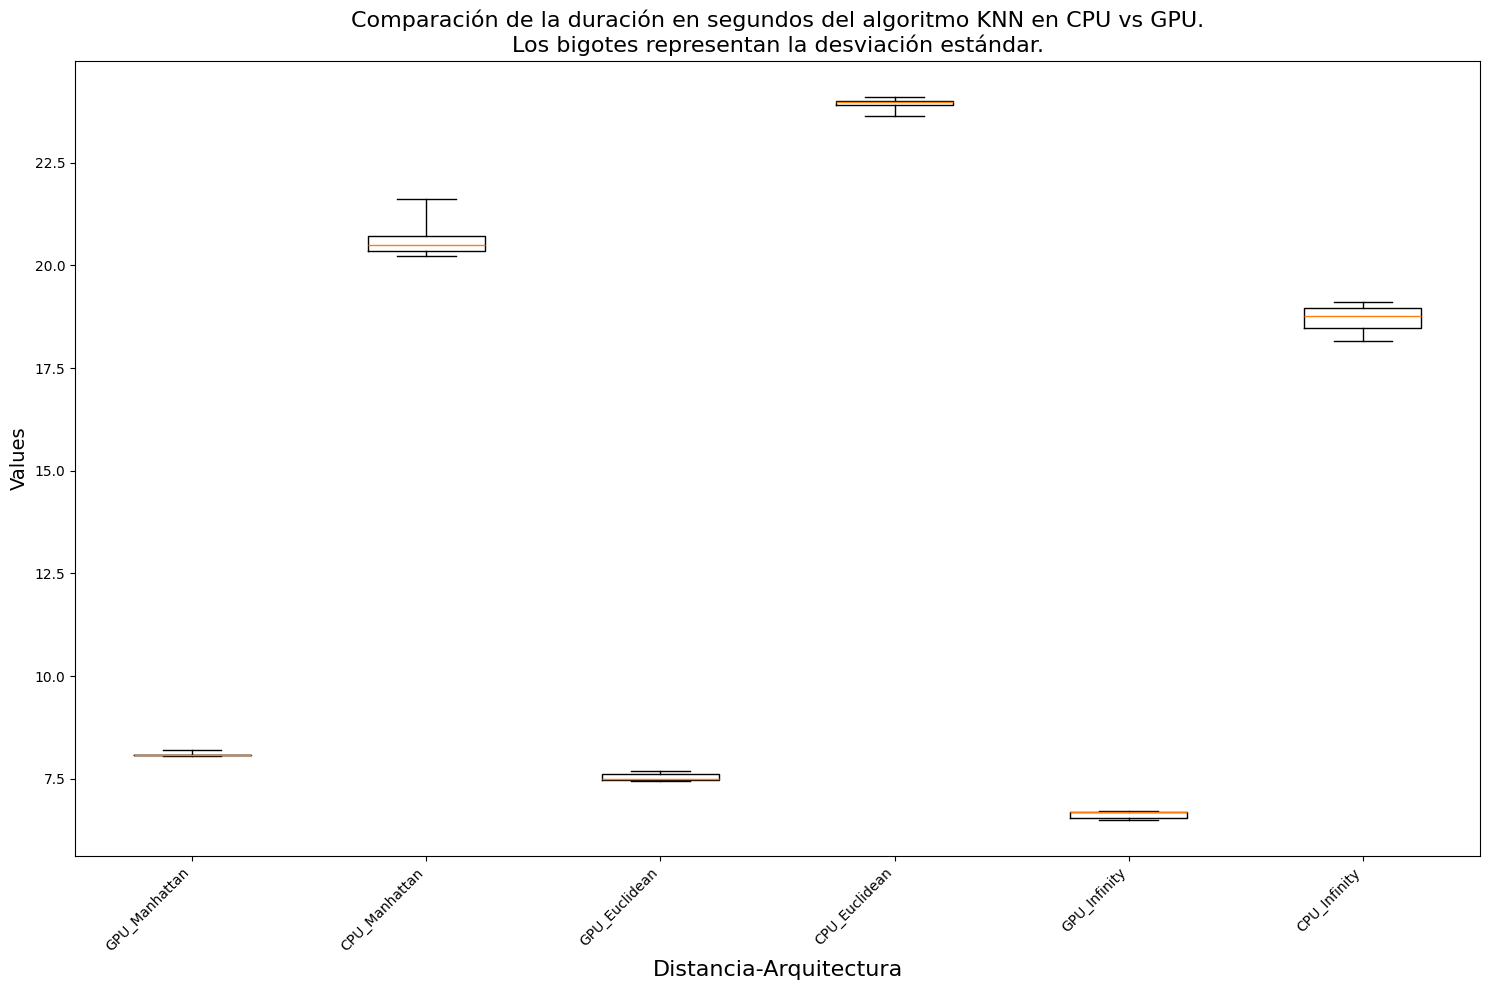

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and axes
fig, ax = plt.subplots(figsize=(15, 10))

# Define the data for the box plots
data = [df['GPU_Manhattan'], df['CPU_Manhattan'], df['GPU_Euclidean'], df['CPU_Euclidean'],
        df['GPU_Infinity'], df['CPU_Infinity']]

# Define labels for each box plot
labels = ['GPU_Manhattan', 'CPU_Manhattan', 'GPU_Euclidean', 'CPU_Euclidean',
          'GPU_Infinity', 'CPU_Infinity']

# Create the box plots with custom whiskers (standard deviation)
ax.boxplot(data, labels=labels, whis=[0, 100], showfliers=False)  # Adjust whis to modify the whiskers

# Set title and labels
ax.set_title('Comparación de la duración en segundos del algoritmo KNN en CPU vs GPU.\nLos bigotes representan la desviación estándar.', fontsize=16)
ax.set_ylabel('Values', fontsize=14)
ax.set_xlabel('Distancia-Arquitectura', fontsize=16)

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()  # Adjust spacing
plt.show()


#4.(30 puntos) Implemente el algoritmo Condensed Nearest Neighbors (CNN) para implementar de forma mas rapida el algoritmo de K-vecinos mas cercano.

El objetivo del algoritmo es eliminar instancias redundantes manteniendo solo los puntos críticos para preservar la estructura de decisión, y realizar inferencia mas rapido.


a)     El algoritmo funciona como sigue, usando un conjunto de datos de entrenamiento $T$:

1.   Comienza con un conjunto vacío condensado $C$.
2.   Escoge aleatoriamente $K$ elementos y se agregan a $C$.
3.   Para cada dato $\overrightarrow{x}_{i}\in T$, que al ejecutarse el algoritmo KNN usando los datos en $C$, es incorrectamente clasificado, usando como etiqueta la estimacion de KNN usando $T$ (*inconsistencia
con el conjunto de datos de entrenamiento*), se agrega su vecino mas cercano en $T$, hasta que la inconsistencia se arregle. De esta forma se podan los elementos que no aportan mayor informacion.


b)     Pruebe usando los mismos datos de prueba de la funcion anterior, las 3 distancias usadas anteriormente. Use $K=7$. Documente el tamaño del dataset generado $S$. Hagalo para 30 corridas y compare los resultados
con el algoritmo original tanto en tasa de aciertos como tiempo de ejecucion en inferencia.


In [ ]:
SamplesAll, TargetsAll = carga_tensores()
SamplesAll.shape[0]

100000

## Funcion para seleccionar K observaciones y sus etiquetas aleatoriamente

In [ ]:
def get_random_sample(data, labels, K=7):
  # data: dataset de features
  # labels: etiquetas de los features
  # k: numero de observaciones a seleccionar aleatoriamente
  # return: 3 tensores, uno con los features seleccionados, las etiquetas y los indices seleccionados

  # Genera una permutacion aleatoria de todas las observaciones
  random_indices = torch.randperm(data.shape[0])

  # Selecciona los primeros K índices aleatorios
  selected_indices = random_indices[:K]

  return data[selected_indices], labels[selected_indices], selected_indices

# prueba
get_random_sample(SamplesAll, TargetsAll, K=4)

(tensor([[22.2046, 18.9900],
         [17.8408, 21.1114],
         [22.8265, 19.2796],
         [18.4673, 16.5570]]),
 tensor([[0.],
         [0.],
         [0.],
         [0.]]),
 tensor([65939, 72061, 60896, 80971]))

## Implementacion de CNN

In [ ]:
from tqdm import trange, tqdm

#4.
def get_distancia(X, v, p=float('inf')):
  if p == float('inf'):
      return torch.max(torch.abs(X - v), dim=1).values.unsqueeze(0)
  return torch.pow(torch.sum(torch.pow(torch.abs(X - v), p), dim=1), 1/p).unsqueeze(0)


def cnn_clasify_observation(C, C_targets, test_observation, p, K):
  # Calcula la distancia entre la observacion de entrada y el dataset de entrenamiento
  dist = get_distancia(C, test_observation, p)
  # print(f"Distancia {p}:\t{dist}")

  # Se seleccionan los K indices con las menores distancias al conjunto condensado C
  k_vecinos = dist.topk(K, largest=False)

  # Extraccion de los labels de los vecinos mas cercanos
  target_labels = C_targets[k_vecinos.indices[0]]

  # La moda se puede usar para obtener el valor más repetido
  # Este valor se convierte en la etiqueta estimada
  return torch.mode(target_labels, 0).values.unsqueeze(0)


def evaluate_cnn_test_dataset(data_training, labels_training, test_dataset, k=7, p=float('inf')):
  # calcula el cnn para cada observacion del test_dataset
  t_estimated_dataset = []
  C, C_targets, indices_agregados = get_random_sample(data_training, labels_training, k)
  mascara = torch.ones(data_training.shape[0], dtype=bool)
  mascara[indices_agregados] = False

  for i, test_observation in tqdm(enumerate(test_dataset)):
    # print("procesando obsearvacion ", i)
    t_consistente = False
    iteracion = 0
    test_target = None
    # Repite la inferencia mientras que la prediccion no sea consitente con el dataset de training
    # o hasta que el dataset condensado sea igual al de training.

    test_target = cnn_clasify_observation(C, C_targets, test_observation, p, k)
    t_consistente = torch.equal(test_target, labels_training[i])

    if not t_consistente:
      training_filtrado = data_training[mascara]
      labels_filtrado = labels_training[mascara]
      dist = get_distancia(training_filtrado, test_observation, p)
      k_vecinos = dist.topk(2, largest=False)
      # print("k_vecinos, ", k_vecinos)

      # Busca el siguiente vecino mas cercano que no sea la misma observacion
      nuevo_vecino = training_filtrado[k_vecinos.indices.squeeze()[-1]].unsqueeze(0)
      etiqueta_nuevo_vecino = labels_filtrado[k_vecinos.indices.squeeze()[-1]].unsqueeze(1)

      # Revisa que el nuevo vecino no este en C antes de agregarlo
      if not torch.any(torch.all(torch.eq(C, nuevo_vecino), dim=1)):
        C = torch.cat((C, nuevo_vecino), dim=0)
        C_targets = torch.cat((C_targets, etiqueta_nuevo_vecino), dim=0)

      mascara[k_vecinos.indices.squeeze()[-1]] = False

    # Agrega valor estimado
    t_estimated_dataset.append(test_target)
  # retorna el tensor condensado, sus etiquetas y las etiquetas estimadas
  return C, C_targets, torch.tensor(t_estimated_dataset).to(data_training.device)




```
`# This is formatted as code`
```

### Pruebas de CNN

In [ ]:
# Create Train/Test sets
X_train, X_test, y_train, y_test = train_test_split(SamplesAll, TargetsAll, test_size=0.30)


In [ ]:
def calcular_accuracy(t_estimados, y_verdadera):
  """Calcula el accuracy de las predicciones.

  Args:
    t_estimados: Tensor con las predicciones (etiquetas estimadas).
    y_verdadera: Tensor con las etiquetas verdaderas.

  Returns:
    Un valor escalar que representa el accuracy (entre 0 y 1).
  """
  # Asegurarse que los tensores tengan la misma forma
  t_estimados = t_estimados.view_as(y_verdadera)

  # Comparar las predicciones con las etiquetas verdaderas
  correctos = (t_estimados == y_verdadera).sum().item()

  # Calcular el accuracy
  accuracy = correctos / len(y_verdadera)

  return accuracy

In [ ]:
sample_size = 1000
C, C_t, t_estimados = evaluate_cnn_test_dataset(X_train[:sample_size], y_train[:sample_size], X_train[:sample_size])
print("Conjunto Condensado shape", C.shape[0])

accuracy = calcular_accuracy(t_estimados, y_train[:sample_size])
print(f"Accuracy: {accuracy}")

1000it [00:00, 4075.58it/s]

Conjunto Condensado shape 580
Accuracy: 0.997


In [ ]:
sample_size = 10000
C, C_t, t_estimados = evaluate_cnn_test_dataset(X_train[:sample_size], y_train[:sample_size], X_train[:sample_size])
print("Conjunto Condensado shape", C.shape)

accuracy = calcular_accuracy(t_estimados, y_train[:sample_size])
print(f"Accuracy: {accuracy}")

10000it [00:08, 1165.44it/s]

Conjunto Condensado shape torch.Size([5758, 2])
Accuracy: 0.9993


In [ ]:
sample_size = 20000
C, C_t, t_estimados = evaluate_cnn_test_dataset(X_train[:sample_size], y_train[:sample_size], X_train[:sample_size])
print("Conjunto Condensado shape", C.shape)

accuracy = calcular_accuracy(t_estimados, y_train[:sample_size])
print(f"Accuracy: {accuracy}")

20000it [00:29, 682.30it/s]

Conjunto Condensado shape torch.Size([11555, 2])
Accuracy: 0.9997


### Pruebas de rendimiento CNN

In [ ]:
seeds = random.sample(range(1, 1000000), 30)

# Imprime las semillas utilizadas (para reproducibilidad)
print(seeds)

[330099, 627190, 328394, 136635, 127848, 601375, 679337, 8142, 100971, 941864, 181219, 532792, 35621, 931818, 724907, 171592, 469831, 890847, 589681, 423511, 132743, 352678, 365785, 652620, 143690, 82815, 288471, 772790, 27216, 325921]


In [12]:
# 4.b GPU
def evalua_con_repeticiones_cnn(samples, targets, k=7, reps = 30):
  results = {
      'Accuracy_Euclidean': [],
      'Duration_Euclidean': [],
      'S_size_Euclidean': [],
      'Accuracy_Manhattan': [],
      'Duration_Manhattan': [],
      'S_size_Manhattan': [],
      'Accuracy_Infinity': [],
      'Duration_Infinity': [],
      'S_size_Infinity': [],
  }

  for index in range(reps):
      # Create Train/Test sets
      X_train, X_test, y_train, y_test = train_test_split(samples,
                                                          targets,
                                                          test_size=0.30,
                                                          random_state=seeds[index])
      print(f'Processing split {index + 1}')
      for p in [1.0, 2.0, float('inf')]:
          start_time = time.time()
          C, C_t, test_estimations = evaluate_cnn_test_dataset(
              data_training=X_train,
              labels_training=y_train,
              test_dataset=X_test,
              k=7,
              p=p
          )
          duration = time.time() - start_time

          #calculate accuracy
          accuracy = calcular_tasa_aciertos(
              test_estimations.unsqueeze(0).transpose(0, 1), y_test)

          distance_type = "Manhattan"
          if p == 2.0:
            distance_type = "Euclidean"
          elif p == float('inf'):
            distance_type = "Infinity"

          results[f'Accuracy_{distance_type}'].append(accuracy)
          results[f'Duration_{distance_type}'].append(duration)
          results[f'S_size_{distance_type}'].append(C.shape[0])

  # Save Pandas DataFrame
  results_df = pd.DataFrame(results)
  return results_df


def estima_aciertos(results_df):
  # Tasa de aciertos por distancia
  accuracy_results = results_df[['Accuracy_Manhattan', 'Accuracy_Euclidean', 'Accuracy_Infinity']]

  # Calculo de medias
  mean = pd.DataFrame(accuracy_results.mean()).transpose()
  mean.index = ["Mean"]

  # Calculo de Std
  std = pd.DataFrame(accuracy_results.std()).transpose()
  std.index = ["Std"]

  # Despliega datos
  accuracy_results = pd.concat([accuracy_results, mean, std])
  return accuracy_results

def estima_duracion(results_df):
  # Duracion
  duration_results = results_df[['Duration_Manhattan', 'Duration_Euclidean', 'Duration_Infinity']]

  # Media de la duracion
  mean = pd.DataFrame(duration_results.mean()).transpose()
  mean.index = ["Mean"]

  # Std de la duracion
  std = pd.DataFrame(duration_results.std()).transpose()
  std.index = ["Std"]

  # Concatena calculos
  duration_results = pd.concat([duration_results, mean, std])
  return duration_results

def estima_tamano_conjunto_condensado(results_df):
  # Duracion
  c_results = results_df[['S_size_Manhattan', 'S_size_Euclidean', 'S_size_Infinity']]

  # Media de la duracion
  mean = pd.DataFrame(c_results.mean()).transpose()
  mean.index = ["Mean"]

  # Std de la duracion
  std = pd.DataFrame(c_results.std()).transpose()
  std.index = ["Std"]

  # Concatena calculos
  c_results = pd.concat([c_results, mean, std])
  return c_results

In [ ]:
gpu_cnn_results_df = evalua_con_repeticiones_cnn(SamplesAll, TargetsAll)
display(gpu_cnn_results_df)

Processing split 1


30000it [02:13, 224.82it/s]
30000it [02:22, 209.94it/s]
30000it [02:09, 231.27it/s]


Processing split 2


30000it [02:15, 221.73it/s]
30000it [02:22, 210.13it/s]
30000it [02:07, 234.81it/s]


Processing split 3


30000it [02:12, 226.48it/s]
30000it [02:22, 210.26it/s]
30000it [02:08, 234.06it/s]


Processing split 4


30000it [02:11, 228.19it/s]
30000it [02:21, 212.62it/s]
30000it [02:07, 235.34it/s]


Processing split 5


30000it [02:12, 226.74it/s]
30000it [02:22, 211.08it/s]
30000it [02:07, 234.98it/s]


Processing split 6


30000it [02:12, 226.81it/s]
30000it [02:21, 212.05it/s]
30000it [02:07, 235.78it/s]


Processing split 7


30000it [02:12, 227.27it/s]
30000it [02:21, 212.01it/s]
30000it [02:07, 234.84it/s]


Processing split 8


30000it [02:11, 227.39it/s]
30000it [02:20, 213.04it/s]
30000it [02:07, 235.89it/s]


Processing split 9


30000it [02:12, 227.23it/s]
30000it [02:18, 216.28it/s]
30000it [02:06, 236.71it/s]


Processing split 10


30000it [02:11, 228.85it/s]
30000it [02:20, 212.81it/s]
30000it [02:07, 234.83it/s]


Processing split 11


30000it [02:11, 227.38it/s]
30000it [02:21, 212.10it/s]
30000it [02:07, 235.59it/s]


Processing split 12


30000it [02:11, 228.02it/s]
30000it [02:19, 215.36it/s]
30000it [02:11, 228.75it/s]


Processing split 13


30000it [02:13, 225.05it/s]
30000it [02:21, 212.45it/s]
30000it [02:08, 234.22it/s]


Processing split 14


30000it [02:12, 226.36it/s]
30000it [02:23, 209.51it/s]
30000it [02:07, 234.92it/s]


Processing split 15


30000it [02:12, 226.80it/s]
30000it [02:21, 211.59it/s]
30000it [02:07, 235.05it/s]


Processing split 16


30000it [02:12, 226.35it/s]
30000it [02:21, 211.42it/s]
30000it [02:07, 235.27it/s]


Processing split 17


30000it [02:10, 229.50it/s]
30000it [02:18, 216.62it/s]
30000it [02:06, 237.52it/s]


Processing split 18


30000it [02:10, 230.00it/s]
30000it [02:17, 217.44it/s]
30000it [02:08, 233.62it/s]


Processing split 19


30000it [02:12, 226.30it/s]
30000it [02:20, 213.44it/s]
30000it [02:08, 233.19it/s]


Processing split 20


30000it [02:12, 227.24it/s]
30000it [02:21, 212.38it/s]
30000it [02:08, 233.76it/s]


Processing split 21


30000it [02:12, 227.03it/s]
30000it [02:19, 214.72it/s]
30000it [02:08, 232.57it/s]


Processing split 22


30000it [02:12, 227.17it/s]
30000it [02:20, 213.43it/s]
30000it [02:08, 234.16it/s]


Processing split 23


30000it [02:11, 227.79it/s]
30000it [02:20, 213.36it/s]
30000it [02:07, 234.41it/s]


Processing split 24


30000it [02:11, 227.97it/s]
30000it [02:20, 213.69it/s]
30000it [02:08, 233.79it/s]


Processing split 25


30000it [02:12, 227.27it/s]
30000it [02:20, 213.93it/s]
30000it [02:07, 234.68it/s]


Processing split 26


30000it [02:11, 228.41it/s]
30000it [02:19, 214.61it/s]
30000it [02:07, 234.92it/s]


Processing split 27


30000it [02:11, 228.62it/s]
30000it [02:20, 214.19it/s]
30000it [02:08, 233.74it/s]


Processing split 28


30000it [02:10, 229.53it/s]
30000it [02:22, 210.52it/s]
30000it [02:08, 232.83it/s]


Processing split 29


30000it [02:10, 229.42it/s]
30000it [02:23, 208.57it/s]
30000it [02:09, 232.49it/s]


Processing split 30


30000it [02:11, 227.54it/s]
30000it [02:20, 214.04it/s]
30000it [02:08, 233.32it/s]


,Accuracy_Euclidean,Duration_Euclidean,S_size_Euclidean,Accuracy_Manhattan,Duration_Manhattan,S_size_Manhattan,Accuracy_Infinity,Duration_Infinity,S_size_Infinity
0,0.999633,142.992771,23015,0.999533,133.533384,23118,0.999567,129.817989,23117
1,0.999700,142.863587,23052,0.999667,135.393794,23118,0.999700,127.857692,23164
2,0.999533,142.892764,23034,0.999567,132.669078,23033,0.999600,128.423708,23156
3,0.999633,141.316893,23091,0.999700,131.726877,23109,0.999667,127.693696,23164
4,0.999733,142.217102,23049,0.999667,132.537363,23047,0.999667,127.795357,23133
5,0.999800,141.568789,23099,0.999800,132.386403,22939,0.999833,127.369217,23133
6,0.999633,141.597677,23148,0.999767,132.123940,23093,0.999733,127.889187,22988
7,0.999633,141.027049,23129,0.999633,132.063238,23030,0.999633,127.390450,23132
8,0.999800,138.913116,23122,0.999833,132.234741,23027,0.999867,126.945611,22978
9,0.999667,141.214799,22960,0.999667,131.289877,23086,0.999667,128.013700,23084


In [ ]:
print('---------------------------------')
print('CNN GPU en latex')
gpu_cnn_results_df.to_latex(index=False)

---------------------------------
CNN GPU en latex


'\\begin{tabular}{rrrrrrrrr}\n\\toprule\nAccuracy_Euclidean & Duration_Euclidean & S_size_Euclidean & Accuracy_Manhattan & Duration_Manhattan & S_size_Manhattan & Accuracy_Infinity & Duration_Infinity & S_size_Infinity \\\\\n\\midrule\n0.999633 & 142.992771 & 23015 & 0.999533 & 133.533384 & 23118 & 0.999567 & 129.817989 & 23117 \\\\\n0.999700 & 142.863587 & 23052 & 0.999667 & 135.393794 & 23118 & 0.999700 & 127.857692 & 23164 \\\\\n0.999533 & 142.892764 & 23034 & 0.999567 & 132.669078 & 23033 & 0.999600 & 128.423708 & 23156 \\\\\n0.999633 & 141.316893 & 23091 & 0.999700 & 131.726877 & 23109 & 0.999667 & 127.693696 & 23164 \\\\\n0.999733 & 142.217102 & 23049 & 0.999667 & 132.537363 & 23047 & 0.999667 & 127.795357 & 23133 \\\\\n0.999800 & 141.568789 & 23099 & 0.999800 & 132.386403 & 22939 & 0.999833 & 127.369217 & 23133 \\\\\n0.999633 & 141.597677 & 23148 & 0.999767 & 132.123940 & 23093 & 0.999733 & 127.889187 & 22988 \\\\\n0.999633 & 141.027049 & 23129 & 0.999633 & 132.063238 & 23030 & 

In [ ]:
archivo_resultados = guarda_pandas_csv(gpu_cnn_results_df, 'cnn_results_gpu')
from google.colab import files
files.download(archivo_resultados)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
print('---------------------------------')
print('Aciertos CNN GPU en latex')
estima_aciertos(gpu_cnn_results_df).to_latex(index=False)

---------------------------------
Aciertos CNN GPU en latex


'\\begin{tabular}{rrr}\n\\toprule\nAccuracy_Manhattan & Accuracy_Euclidean & Accuracy_Infinity \\\\\n\\midrule\n0.999533 & 0.999633 & 0.999567 \\\\\n0.999667 & 0.999700 & 0.999700 \\\\\n0.999567 & 0.999533 & 0.999600 \\\\\n0.999700 & 0.999633 & 0.999667 \\\\\n0.999667 & 0.999733 & 0.999667 \\\\\n0.999800 & 0.999800 & 0.999833 \\\\\n0.999767 & 0.999633 & 0.999733 \\\\\n0.999633 & 0.999633 & 0.999633 \\\\\n0.999833 & 0.999800 & 0.999867 \\\\\n0.999667 & 0.999667 & 0.999667 \\\\\n0.999733 & 0.999700 & 0.999667 \\\\\n0.999633 & 0.999600 & 0.999667 \\\\\n0.999667 & 0.999767 & 0.999733 \\\\\n0.999833 & 0.999767 & 0.999867 \\\\\n0.999633 & 0.999567 & 0.999633 \\\\\n0.999633 & 0.999733 & 0.999767 \\\\\n0.999800 & 0.999833 & 0.999867 \\\\\n0.999633 & 0.999700 & 0.999700 \\\\\n0.999733 & 0.999733 & 0.999767 \\\\\n0.999700 & 0.999700 & 0.999700 \\\\\n0.999567 & 0.999667 & 0.999533 \\\\\n0.999700 & 0.999700 & 0.999667 \\\\\n0.999567 & 0.999633 & 0.999567 \\\\\n0.999667 & 0.999700 & 0.999733 \\\\\n

In [17]:
print('---------------------------------')
print('Duracion CNN GPU en latex')
estima_duracion(gpu_cnn_results_df).to_latex(index=False)

---------------------------------
Duracion CNN GPU en latex


'\\begin{tabular}{rrr}\n\\toprule\nDuration_Manhattan & Duration_Euclidean & Duration_Infinity \\\\\n\\midrule\n133.533384 & 142.992771 & 129.817989 \\\\\n135.393794 & 142.863587 & 127.857692 \\\\\n132.669078 & 142.892764 & 128.423708 \\\\\n131.726877 & 141.316893 & 127.693696 \\\\\n132.537363 & 142.217102 & 127.795357 \\\\\n132.386403 & 141.568789 & 127.369217 \\\\\n132.123940 & 141.597677 & 127.889187 \\\\\n132.063238 & 141.027049 & 127.390450 \\\\\n132.234741 & 138.913116 & 126.945611 \\\\\n131.289877 & 141.214799 & 128.013700 \\\\\n132.170402 & 141.679312 & 127.597317 \\\\\n131.667596 & 139.397098 & 131.245120 \\\\\n133.399529 & 141.304056 & 128.178592 \\\\\n132.631422 & 143.291103 & 127.795894 \\\\\n132.373399 & 141.993658 & 127.841204 \\\\\n132.757726 & 142.110632 & 127.716514 \\\\\n130.994651 & 138.689353 & 126.408652 \\\\\n130.553321 & 138.079915 & 128.517499 \\\\\n132.663919 & 140.652479 & 128.745878 \\\\\n132.116978 & 141.348709 & 128.542116 \\\\\n132.343963 & 139.911365 & 12

In [19]:
print('---------------------------------')
print('Duracion CNN GPU en latex')
estima_tamano_conjunto_condensado(gpu_cnn_results_df).to_latex(index=False)

---------------------------------
Duracion CNN GPU en latex


'\\begin{tabular}{rrr}\n\\toprule\nS_size_Manhattan & S_size_Euclidean & S_size_Infinity \\\\\n\\midrule\n23118.000000 & 23015.000000 & 23117.000000 \\\\\n23118.000000 & 23052.000000 & 23164.000000 \\\\\n23033.000000 & 23034.000000 & 23156.000000 \\\\\n23109.000000 & 23091.000000 & 23164.000000 \\\\\n23047.000000 & 23049.000000 & 23133.000000 \\\\\n22939.000000 & 23099.000000 & 23133.000000 \\\\\n23093.000000 & 23148.000000 & 22988.000000 \\\\\n23030.000000 & 23129.000000 & 23132.000000 \\\\\n23027.000000 & 23122.000000 & 22978.000000 \\\\\n23086.000000 & 22960.000000 & 23084.000000 \\\\\n23163.000000 & 23109.000000 & 23111.000000 \\\\\n23100.000000 & 22966.000000 & 23215.000000 \\\\\n23192.000000 & 22978.000000 & 23069.000000 \\\\\n23066.000000 & 23150.000000 & 23210.000000 \\\\\n23130.000000 & 23069.000000 & 23119.000000 \\\\\n23154.000000 & 23094.000000 & 23153.000000 \\\\\n23055.000000 & 23063.000000 & 23116.000000 \\\\\n23100.000000 & 23036.000000 & 23105.000000 \\\\\n23139.000000

In [24]:
import pandas as pd
data = {
    'Corrida': list(range(1, 11)),
    'GPU_Manhattan': [8.086052, 8.071934, 8.194681, 8.067917, 8.088926, 8.115149, 8.072658, 8.052628, 8.092654, 8.062700],
    'CPU_Manhattan': [21.610155, 20.520020, 20.791444, 20.350141, 20.234142, 20.754730, 20.381359, 20.497603, 20.341320, 20.645990],
    'GPU_Euclidean': [7.471702, 7.450645, 7.468749, 7.519531, 7.452440, 7.476169, 7.662809, 7.686365, 7.627234, 7.618219],
    'CPU_Euclidean': [24.006129, 24.019213, 24.013317, 23.636163, 24.011520, 24.103350, 23.968350, 23.902102, 23.946782, 23.823238],
    'GPU_Infinity': [6.696899, 6.677324, 6.674734, 6.690659, 6.705777, 6.715930, 6.503448, 6.516738, 6.501912, 6.699250],
    'CPU_Infinity': [18.805519, 18.755920, 18.379076, 18.966814, 19.095105, 18.729428, 19.104312, 18.150882, 18.267952, 18.936353],

}

df = pd.DataFrame(data)
display(df)


,Corrida,GPU_Manhattan,CPU_Manhattan,GPU_Euclidean,CPU_Euclidean,GPU_Infinity,CPU_Infinity
0,1,8.086052,21.610155,7.471702,24.006129,6.696899,18.805519
1,2,8.071934,20.520020,7.450645,24.019213,6.677324,18.755920
2,3,8.194681,20.791444,7.468749,24.013317,6.674734,18.379076
3,4,8.067917,20.350141,7.519531,23.636163,6.690659,18.966814
4,5,8.088926,20.234142,7.452440,24.011520,6.705777,19.095105
5,6,8.115149,20.754730,7.476169,24.103350,6.715930,18.729428
6,7,8.072658,20.381359,7.662809,23.968350,6.503448,19.104312
7,8,8.052628,20.497603,7.686365,23.902102,6.516738,18.150882
8,9,8.092654,20.341320,7.627234,23.946782,6.501912,18.267952
9,10,8.062700,20.645990,7.618219,23.823238,6.699250,18.936353
